# Advanced Machine Learning : Projet 2

The goal of the project is to provide a model able to predict for a given scientific article on NLP the year of publication. We used the same data as the first project but in a supervised way. We will compare prediction of the different modelsby using the mean squared error (MSE), since making a mistake of ten years or one year it’s not as important.

The two main expectations of the project are:

1) propose models to predict the year of publication for a given article and explain all our modifications step by step, in order to improve the results.

2) analyse the results : Which years are more difficult ? Why ? Which articles are more difficult, or which key-words are considered more difficult ?

Dataset (44MB): https://www.ortolang.fr/market/corpora/corpus-taln

For our project we decided to focus on the articles' abstracts to predict the year of publication for a given article. To illustrate this, we will use six distinct machine learning models :
* Linear Regression
* Lasso
* Ridge
* Random Forest
* ElasticNet
* Huber

In closing, we will analyze and compare the evaluation of the supervised machine models selected above. 

# Imports, Installations and Downloads


In [ ]:
# Installations
!pip install git+https://github.com/ClaudeCoulombe/FrenchLefffLemmatizer.git

# NLTK imports
import nltk
from nltk.tag import UnigramTagger
from nltk.corpus import treebank, stopwords, wordnet
from nltk.tokenize import TreebankWordTokenizer, RegexpTokenizer 
from nltk.stem import WordNetLemmatizer

# Basic imports
from google.colab import drive
import unicodedata
import xml.etree.ElementTree as ET
import pandas as pd
import numpy as np

# spacy
import spacy
sp = spacy.load('en_core_web_sm')


# Sklearn imports
from sklearn.feature_extraction.text import TfidfVectorizer

import matplotlib.pyplot as plt
from french_lefff_lemmatizer.french_lefff_lemmatizer import FrenchLefffLemmatizer

from sklearn.model_selection import train_test_split  
from sklearn.linear_model import Ridge, Lasso, LassoCV, ElasticNet,ElasticNetCV, HuberRegressor, LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.feature_extraction.text import TfidfVectorizer


# Download packets
nltk.download('treebank')
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')

# PREPROCESSING

Data preprocessing is an important step in the data exploration process.

### **Importing data**


In [ ]:
drive.mount('/content/drive')
tree = ET.parse('/content/drive/MyDrive/ProjetNLP/corpus_taln_v1.tei.xml')
root = tree.getroot()

## **Raw data to Dataframe**

For this project, the data was in the form of an xml file. Before starting we had to explore and navigate through the file to identify the different fields and get a better understanding of the structure. Once we’ve completed this step, we decided to retrieve only a few fields : the date, abstract in french and abstract in english.

That's what we're doing in the following section. First we define the path of data we want to retrieve, then we collect it and store it into arrays

In [ ]:
path_date = "./{http://www.tei-c.org/ns/1.0}TEI/{http://www.tei-c.org/ns/1.0}teiHeader/{http://www.tei-c.org/ns/1.0}fileDesc/{http://www.tei-c.org/ns/1.0}publicationStmt/{http://www.tei-c.org/ns/1.0}date"
path_abstractFR = "./{http://www.tei-c.org/ns/1.0}TEI/{http://www.tei-c.org/ns/1.0}text/{http://www.tei-c.org/ns/1.0}front/{http://www.tei-c.org/ns/1.0}div[@type='abstract'][1]/{http://www.tei-c.org/ns/1.0}p" 
path_abstractEN = "./{http://www.tei-c.org/ns/1.0}TEI/{http://www.tei-c.org/ns/1.0}text/{http://www.tei-c.org/ns/1.0}front/{http://www.tei-c.org/ns/1.0}div[@type='abstract'][2]/{http://www.tei-c.org/ns/1.0}p"

Extracting data from XML

In [ ]:
articles_date = []
for node in root.findall(path_date):
  articles_date.append(node.text)

articles_abstractFR = []
for node in root.findall(path_abstractFR):
  articles_abstractFR.append(node.text)

articles_abstractEN = []
for node in root.findall(path_abstractEN):
  articles_abstractEN.append(node.text)

Once we were able to get the data from the different fields, we stored the data into a dataframe so it would be easier to use.

In [ ]:
df = pd.DataFrame(list(zip(articles_date, articles_abstractFR, articles_abstractEN )), 
               columns =['date', 'abstractFR', 'abstractEN']) 
df.head()

,date,abstractFR,abstractEN
0,1997,\nNous considérons dans notre travail la tâche...,None
1,1997,\nNous donnons ici un aperçu du logiciel DECID...,None
2,1997,\nDiverses méthodes ont été proposées pour con...,None
3,1998,\nLe terme de lambda-DRT désigne un ensemble d...,None
4,1998,"\nDans cet article, nous comparons deux modèle...",None


## **Data cleaning**

Data cleaning is a very crucial step in any machine learning model, but more so for NLP. Without the cleaning process, the dataset is often a cluster of words that the computer doesn’t understand. Here, we will go over steps done in a typical machine learning text pipeline to clean data.

### Remove special characters
To start of, we replace words containing an apostrophe. Then, we remove special characters, one character sentence, new lines and None. Lastly, we lowercase the words.

In [ ]:
columns = ['date','abstractFR', 'abstractEN']

replacement = (("[Dd]'", "de "),("[Qq]u'", "que "), 
               ("[Ll]'", "le "), ("[Jj]'", "je "),
               ("[Cc]'", "ce "), ("[Ss]'", "se "),
               ("[Nn]'", "ne "), ("[Mm]'", "me "),
               ("[Tt]'", "te "),  ("'ll", " will"),
               ("I'm", "i am"),("'d", " would"), 
               ("'s", " is"),("n't", " not"), 
               ("'ve", " have") , ("'re", " are")
               )


for col in columns: 
  for r in replacement:
    # replace words containing an apostrophe 
    df[col] = df[col].str.replace(*r)
  # remove special characters, One character sentence, new lines and None
  df[col] = df[col].str.replace('[\-\[\]+;\'!\^:/,"#&@\(\)\$\?%\_\*«»]|[A-Z]\.|None|\n', '')
  # lowercase words
  df[col] = df[col].str.lower()

# remove french accents
def remove_accented_chars(text):
  t = unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode('utf-8', 'ignore')
  return t

df['abstractFR'] = df.apply(lambda row : remove_accented_chars(row['abstractFR']), axis=1 )

We can't process two languages at the same time without introducing bias to our models.

To answer this problem on more complete data, we thought about translating the missing abstracts but we were not sure about the efficiency of the translation. 

Thus we decided to split our data by language. The first dataframe contains english abstracts and their publication dates. The second contains the same informations for the french abstracts.

In [ ]:
df_EN =df.iloc[:,[0,2]] 
df_FR =df.iloc[:,0:2]

In [ ]:
df_EN=df_EN[df_EN.abstractEN != ""]
df_FR=df_FR[df_FR.abstractFR != ""]

In [ ]:
df_EN.dropna(inplace=True)
df_FR.dropna(inplace=True)

In [ ]:
df_EN.isna().sum()

date          0
abstractEN    0
dtype: int64

## **Stopwords**

We remove the commonly used words. Later, we might need to add some stopwords. 

As a result of the previous project, we added "cet" and "cette" to our french stopwords.



In [ ]:
stop_en = stopwords.words('english')
stop_fr = stopwords.words('french')
stop_fr.append("cet")
stop_fr.append("cette")

In [ ]:
df_FR['abstractFR'] = df_FR['abstractFR'].apply(lambda x : ' '.join([word.lower() for word in x.split() if word.lower() not in stop_fr])) 
df_EN['abstractEN'] = df_EN['abstractEN'].apply(lambda x : ' '.join([word.lower() for word in x.split() if word.lower() not in stop_en])) 

## **Lemmatization**

This is another technique used to reduce words to a normalized form. In lemmatization, the transformation uses a dictionary to map different variants of a word back to its root format. So, with this approach, we are able to reduce non trivial inflections such as “is”, “was”, “were” back to the root “be”.

> English Lemmatization

In [ ]:
def lemmatizeEN(sentence): 
  lemmatized_sentence = []
  words = sp(sentence)
  for word in words: 
    lemmatized_sentence.append(word.lemma_)
  return ' '.join(lemmatized_sentence)

In [ ]:
df_EN['abstractEN'] = df_EN.apply(lambda row : lemmatizeEN(row['abstractEN']), axis=1 )

> French Lemmatization

We proceeded by doing the french lemmatization but we concluded that the results were not as good as the english lemmatization.



In [ ]:
lemmatizer=FrenchLefffLemmatizer()
tokenizer = TreebankWordTokenizer()

def lemmatize_text(t):
  t = tokenizer.tokenize(t)
  t = ' '.join([lemmatizer.lemmatize(word) for word in t])
  return t

In [ ]:
df_FR['abstractFR'] = df_FR.apply(lambda row : lemmatize_text(row['abstractFR']), axis=1)

At first we thought of using classification to solve the problem. However, after some thoughts, we decided to consider the year as a continuous variable rather than a categorical variable to be able to proceed with regression. Therefore the first step was to convert the date from a string to an integer.

In [ ]:
df_EN['date'] = df_EN['date'].astype(int)
df_FR['date'] = df_FR['date'].astype(int)

# Processing abstracts

## **TF-IDF**

Statistical approaches such as machine learning and deep learning work well with numerical data. However, natural language consists of words and sentences.

Therefore, before building a model, we need to convert text to numbers. Several approaches have been developed for converting text to numbers. Bag of Words, N-grams, and Word2Vec model are some of them.

However, in this project, we will use the TF-IDF scheme in order to convert text to numbers. The idea behind TF-IDF is that the words that occur more frequently in one document and less frequently in other documents should be given more importance as they are more useful for classification. 

**Hyperparameters**

* TF-IDF is a product of two terms : TF and IDF. Term Frequency is equal to the number of times a word occurs in a specific document.

* Tf is “n” (natural) by default, “l” (logarithmic) when sublinear_tf=True. Idf is “t” when use_idf is given, “n” (none) otherwise. Normalization is “c” (cosine) when norm='l2', “n” (none) when norm=None.

* max_df = 3 means "ignore terms that appear in more than 3 documents".

* If bytes or files are given to analyze, latin-1 is used to decode.

* The lower and upper boundary of the range of n-values for different n-grams to be extracted. All values of n such that min_n <= n <= max_n will be used. For example in our case, we used (1, 2) which means unigrams and bigrams.


In [ ]:
tfidf = TfidfVectorizer(sublinear_tf=True, min_df=3, norm='l2', encoding='latin-1', ngram_range=(1, 2))
XEnglish = tfidf.fit_transform(df_EN.abstractEN).toarray()
yEnglish = df_EN.date
XEnglish.shape, yEnglish.shape

((1264, 4954), (1264,))

We can see that for the 1264 english abstracts, we will process 4954 different words. As for the 1534 french abstracts we will process 3745 distinct words.

In [ ]:
tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5, norm='l2', encoding='latin-1', ngram_range=(1, 2))
XFrench = tfidf.fit_transform(df_FR.abstractFR).toarray()
yFrench = df_FR.date
XFrench.shape, yFrench.shape

((1534, 3745), (1534,))

**Function**

In order to have an efficient and unified way to call our models, we designed a function to call any scikit-learn models and plot the results. 

For each model, we decided to plot  : 

* **Predicted vs Original values** : This plot shows, in red, the values predicted by the model for each sample of the test set and the original values in blue.
* **Relative distribution** : This plot shows, in red, the sum of predicted values for the distinct years and in dark blue, the sum of original values for the distinct years. This plot is really useful because it allows us to determine if our model only predicts mean values or if it predicts on the entire spectrum of possible values.
* **Relative error** : This plot shows the relative error for each year. The relative error is defined as the ratio of the absolute error of the measurement to the actual measurement.


In [ ]:
mseModelsEN= []
nameModelsEN= []
mseModelsFR= []
nameModelsFR= []
def models(modelName, lang='EN'):
  # name of the model
  name = str(modelName).split("(")[0] + ' - ' + lang
  # fit the train data to the model
  model = modelName.fit(X_train, y_train)
  # round the predicted values so they become integer and not floats
  ypred = np.round(model.predict(X_test), 0)
  # Mean Square Error
  mse = mean_squared_error(y_test, ypred)

  if lang == 'EN':
    mseModelsEN.append(mse)
    nameModelsEN.append(name)
  else:
    mseModelsFR.append(mse)
    nameModelsFR.append(name)

  print("Model : " + name)
  print("MSE: " + str(mse))

  # plot the predicted vs Original values of the current model
  fig, ax = plt.subplots(figsize=(12,8))
  x_ax = range(len(X_test))
  plt.scatter(x_ax, y_test, s=3, color="blue", label="original")
  plt.plot(x_ax, ypred, lw=0.8, color="red", label="predicted")  
  plt.title('Predicted vs Original values for ' + name)
  plt.legend()
  plt.show()

  # plot the relative distribution of the current model
  fig, ax = plt.subplots(figsize=(12,8))
  plt.hist(ypred, color='red', alpha=0.5, label='Prediction')
  plt.hist(y_test, color='darkblue', alpha=0.5, label='True year')
  plt.legend()
  plt.title('Relative distribution with ' + name)
  plt.xlabel('Relative')
  plt.ylabel('Count')
  plt.show()

  # plot the relative error of the current model
  fig, ax = plt.subplots(figsize=(12,8))
  error = ypred - y_test
  m, b = np.polyfit(y_test, error, 1)
  plt.scatter(y_test, error, color='#349eeb', alpha=0.5)
  plt.plot(y_test, m * y_test + b, color='#fff', linewidth=3) 
  plt.plot(y_test, m * y_test + b, color='#349eeb', label=f'Linear regression') 
  plt.axhline(y=0, xmin=0, xmax=1, linestyle='--', color='#e332e6', label='Perfect fit line')
  plt.legend()
  plt.title('Relative error with ' + name)
  plt.xlabel('real year')
  plt.ylabel('Relative error')
  plt.show()

## Processing english abstract

As we already split our dataset by language, we chose to not use a validation set because there would have not been enough data to test our trained models.

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(XEnglish, yEnglish, test_size=0.2, random_state=0, shuffle=True)

## **Linear Regression**

 Linear regression is a simple machine learning algorithm that builds a model to identify the relationship between independent (predictor) and dependent (response) variables.

It fits a linear model with coefficients w = (w1, …, wp) to minimize the residual sum of squares between the observed targets in the dataset, and the targets predicted by the linear approximation.


Model : LinearRegression - EN
MSE: 56.09090909090909


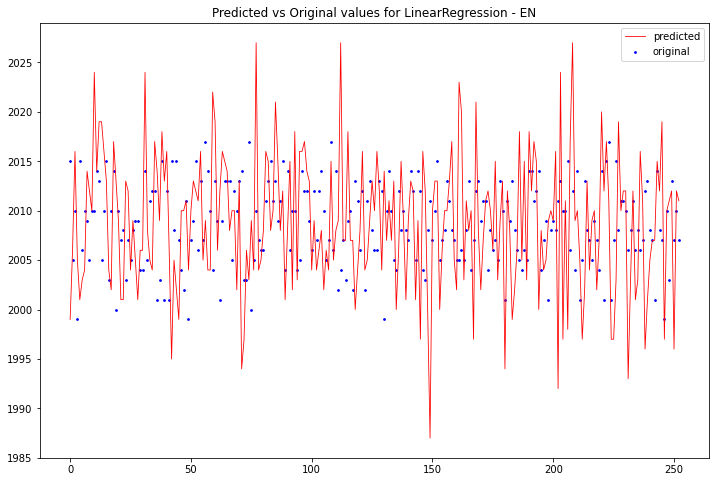

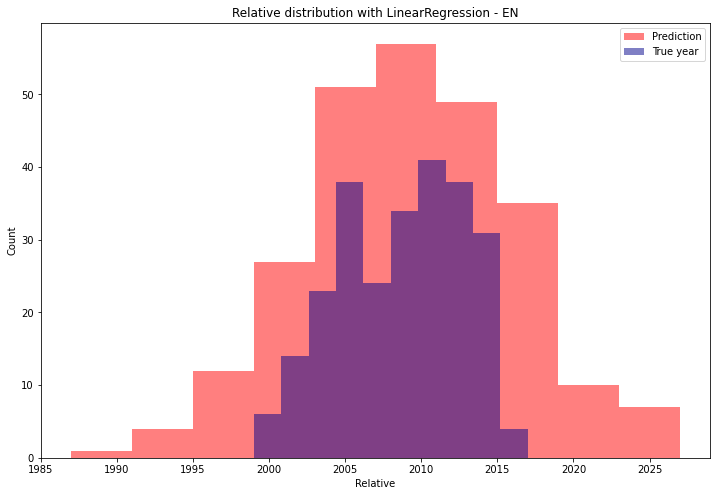

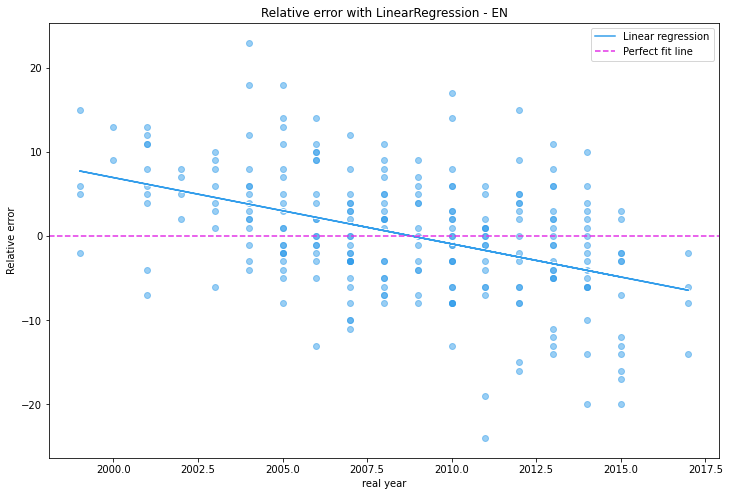

In [ ]:
models(LinearRegression())

With Linear Regression, we have a MSE of 47.6 (which implies a RMSE egal to 6.899). It's realy high because the range of possible years is around 20 years.



## **Ridge Regression**

Ridge method applies L2 regularization to reduce overfitting in the regression model.

This model solves a regression model where the loss function is the linear least squares function and regularization is given by the l2-norm.

### Best alphas 

Alpha is an important factor in regularization. It defines Ridge shrinkage or regularization strength. The higher value means the stronger regularization. We don't know which value works efficiently for our regularization method. Thus we'll figure out the best alpha value by checking the model accuracy with setting multiple alpha values.

We can define Ridge model by setting alpha and fit it with x, y data. Then we check the R-squared, MSE, RMSE values for each alpha.

After testing the different alphas, we'll define the Ridge model again with alpha = 1 
as the MSE is at its lowest point.



In [ ]:
alphas = [0.000001, 0.00001, 0.0001, 0.001, 0.01, 0.1,0.5, 1]
for a in alphas:
  model = Ridge(alpha=a, normalize=True).fit(X_train,y_train) 
  score = model.score(X_test, y_test)
  pred_y = model.predict(X_test)
  mse = mean_squared_error(y_test, pred_y) 
  print("Alpha:{0:.6f}, R2:{1:.3f}, MSE:{2:.2f}, RMSE:{3:.2f}"
      .format(a, score, mse, np.sqrt(mse)))

Alpha:0.000001, R2:0.054, MSE:16.37, RMSE:4.05
Alpha:0.000010, R2:0.054, MSE:16.37, RMSE:4.05
Alpha:0.000100, R2:0.054, MSE:16.37, RMSE:4.05
Alpha:0.001000, R2:0.054, MSE:16.37, RMSE:4.05
Alpha:0.010000, R2:0.055, MSE:16.35, RMSE:4.04
Alpha:0.100000, R2:0.064, MSE:16.18, RMSE:4.02
Alpha:0.500000, R2:0.095, MSE:15.65, RMSE:3.96
Alpha:1.000000, R2:0.118, MSE:15.26, RMSE:3.91


Model : Ridge - EN
MSE: 15.525691699604742


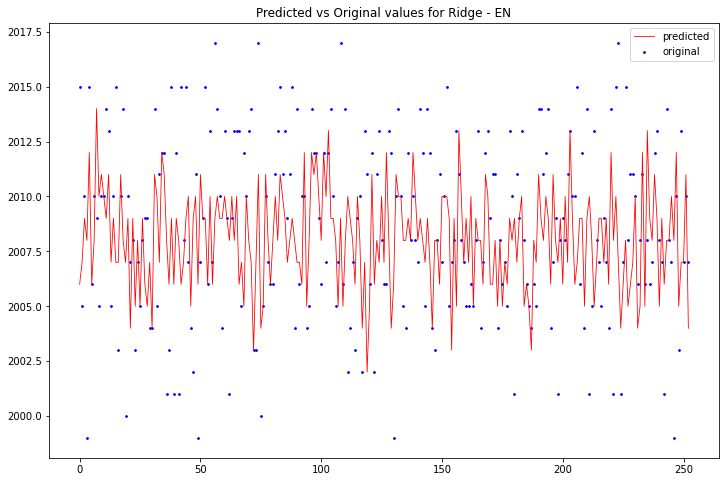

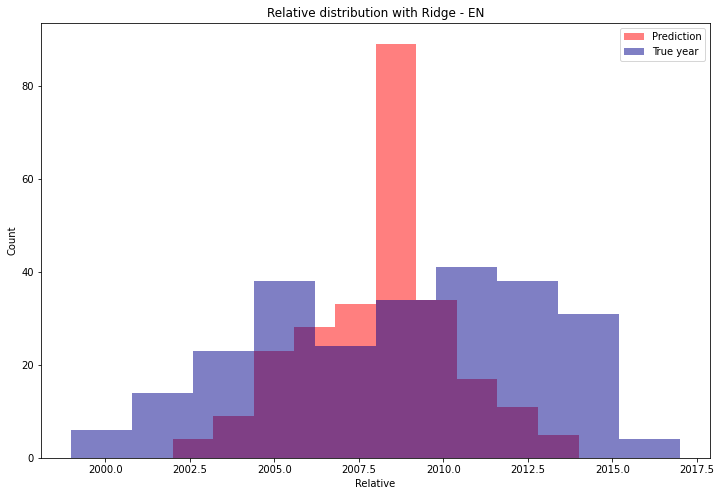

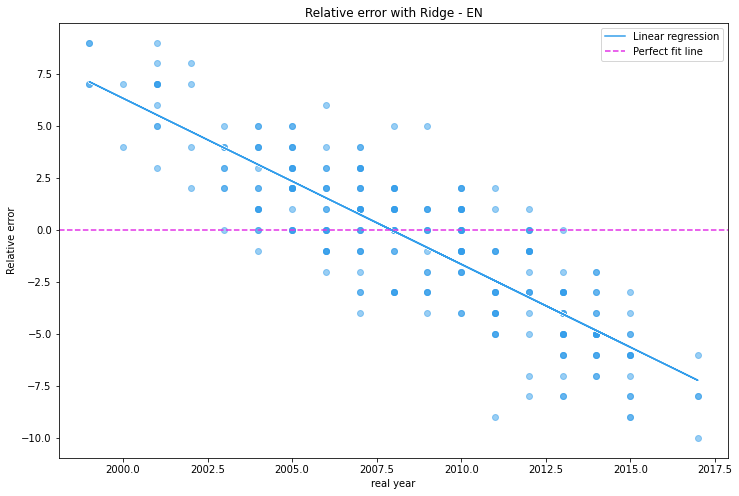

In [ ]:
models(Ridge(alpha=1, normalize=True))

Using Ridge Regression, we have a better MSE than previously with Linear Regression.On the second plot, we can see that the model can't predict correctly the extreme values of our data and tend to predict around the mean.

## **Lasso**

 LASSO (Least Absolute Shrinkage and Selection Operator) is a regularization method to minimize overfitting in a model. It reduces large coefficients with L1-norm regularization which is the sum of their absolute values. The penalty pushes the coefficients with lower value to be zero, to reduce the model complexity.

LassoCV applies cross-validation method to find out the best model. We'll set multiple alpha values and to train the model.

After testing the different alphas, we'll define the Ridge model again with alpha = 0.0001
as the MSE is at its lowest point.



/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9.375056717642186, tolerance: 1.5088275990099005
  positive)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 13.622721806879138, tolerance: 1.4963142150803481
  positive)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 8.180656456977268, tolerance: 1.5374002472187882
  positive)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9.546676

Model : LassoCV - EN
MSE: 20.31620553359684


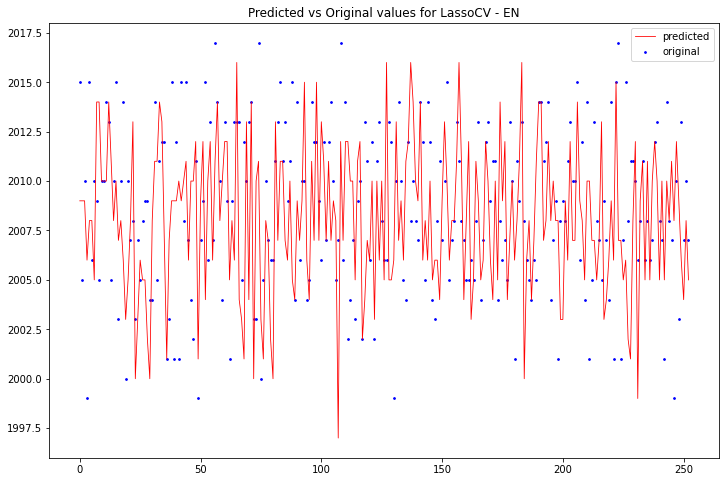

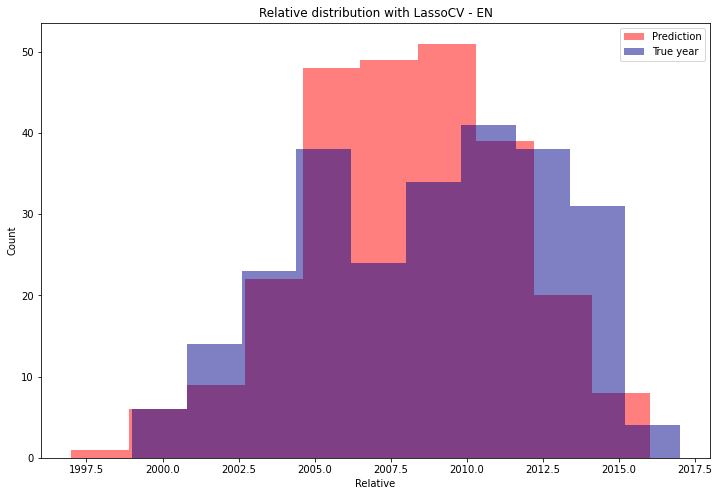

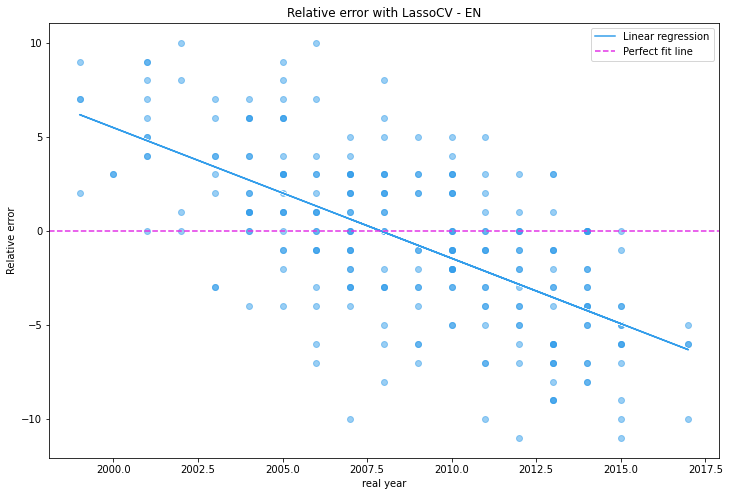

In [ ]:
models(LassoCV(alphas=[0.00001], cv=5))

Here, we can see on the second plot that the model has been able to predict on the whole range of the data, even if it tended to predict around the mean.Furthermore, we have a MSE egal to 19.11, and so a RMSE egal to 4.37, it's still high but in progress.

## **Elastic Net**

ElasticNet regularization applies both L1-norm and L2-norm regularization to penalize the coefficients in a regression model.

To figure out what alpha value is good for our model, we'll define multiple values and check the performance accuracy.

alphas = [0.0001, 0.001, 0.01, 0.1, 0.3, 0.5, 0.7, 1]

We define ElasticNet model by setting alpha and train it with x and y data. Then, we'll check the R-squared, MSE, and RMSE metrics for each alpha.


In [ ]:
alphas = [0.0001, 0.001, 0.01, 0.1, 0.3, 0.5, 0.7, 1]
for a in alphas:
    model = ElasticNet(alpha=a).fit(X_train,y_train)   
    score = model.score(X_test, y_test)
    pred_y = model.predict(X_test)
    mse = mean_squared_error(y_test, pred_y)   
    print("Alpha:{0:.4f}, R2:{1:.2f}, MSE:{2:.2f}, RMSE:{3:.2f}"
       .format(a, score, mse, np.sqrt(mse)))

Alpha:0.0001, R2:0.13, MSE:15.05, RMSE:3.88
Alpha:0.0010, R2:0.20, MSE:13.89, RMSE:3.73
Alpha:0.0100, R2:0.05, MSE:16.39, RMSE:4.05
Alpha:0.1000, R2:-0.00, MSE:17.30, RMSE:4.16
Alpha:0.3000, R2:-0.00, MSE:17.30, RMSE:4.16
Alpha:0.5000, R2:-0.00, MSE:17.30, RMSE:4.16
Alpha:0.7000, R2:-0.00, MSE:17.30, RMSE:4.16
Alpha:1.0000, R2:-0.00, MSE:17.30, RMSE:4.16


Model : ElasticNet - EN
MSE: 13.802371541501977


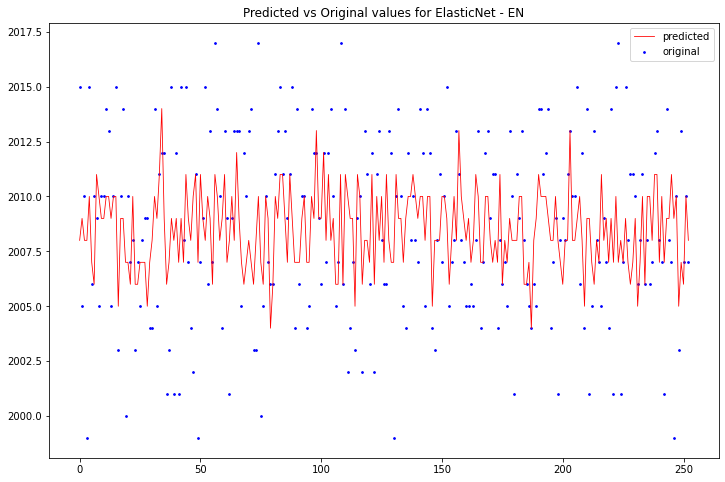

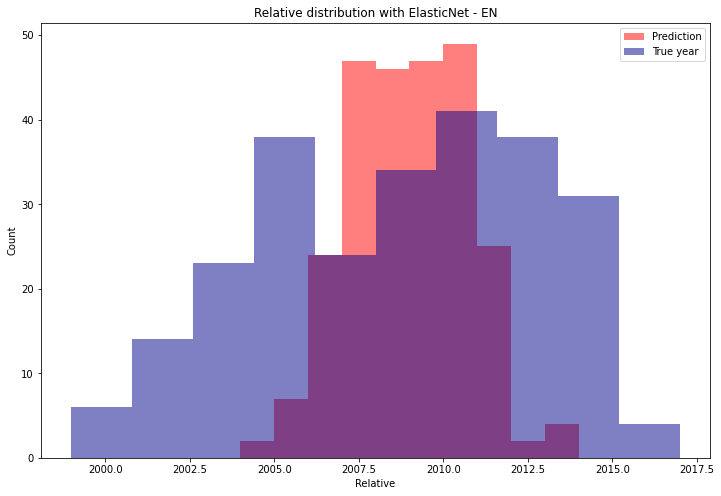

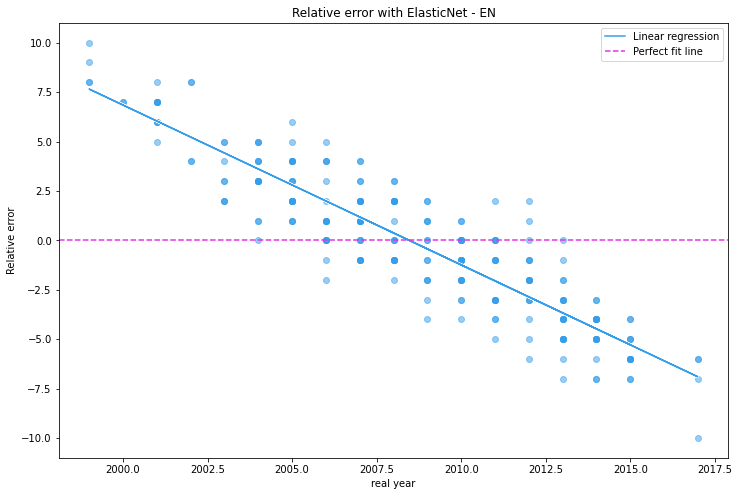

In [ ]:
models(ElasticNet(alpha=0.001))

For the ElasticNet model, we have a MSE of 13.89, meaning a RMSE of 3.72. It's our best RMSE until now but on the second plot we can see that it always predicts around the mean value.

## **Random Forest** 

A Random Forest is an ensemble technique capable of performing both regression and classification tasks with the use of multiple decision trees and a technique called Bootstrap Aggregation, commonly known as bagging. Bagging, in the Random Forest method, involves training each decision tree on a different data sample where sampling is done with replacement.

The basic idea behind this is to combine multiple decision trees in determining the final output rather than relying on individual decision trees.

Model : RandomForestRegressor - EN
MSE: 16.063241106719367


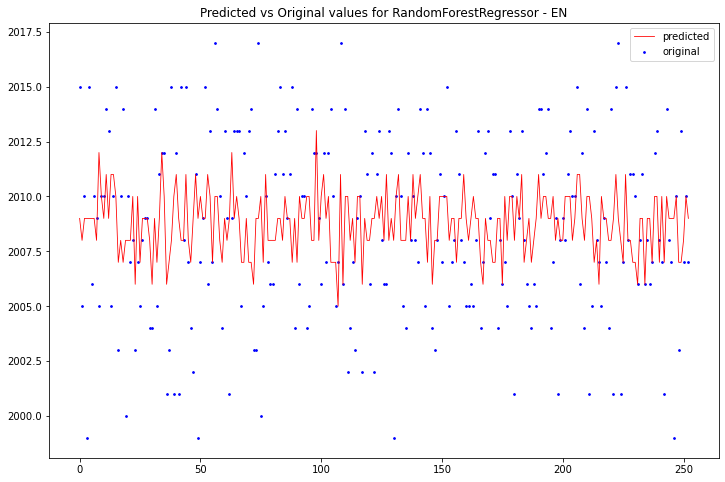

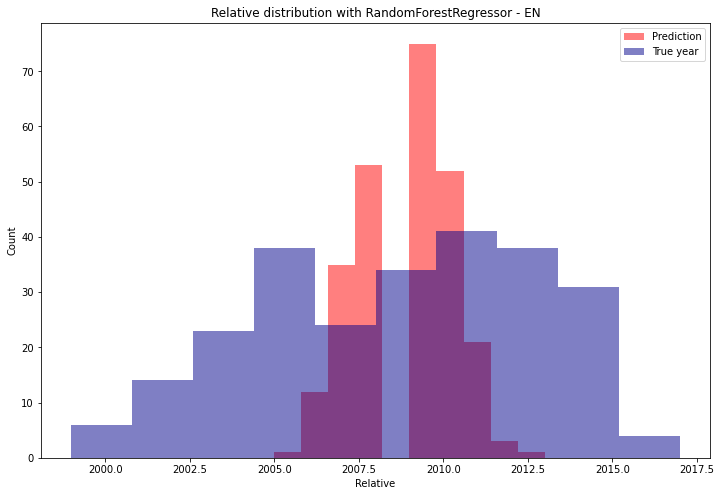

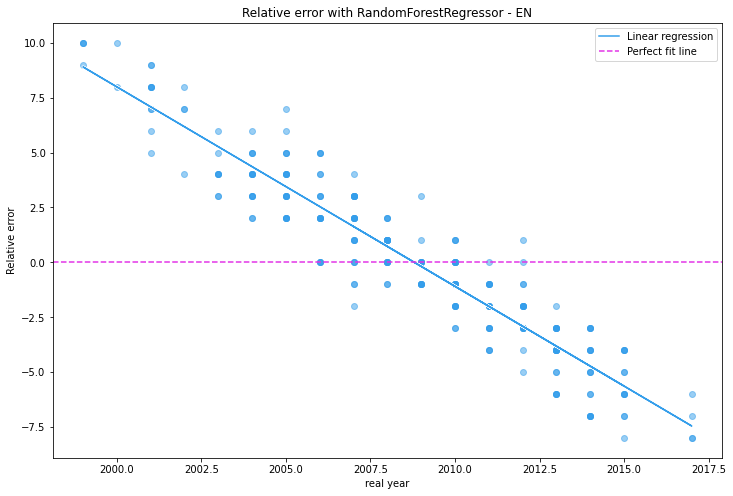

In [ ]:
models(RandomForestRegressor())

For the Random Forest model, we have a MSE of 15.72. As the previous models, the predicted values are still centered.

## **Huber**

Huber regression is a type of robust regression that is aware of the possibility of outliers in a dataset and assigns them less weight than other examples in the dataset.

The Huber Regressor optimizes the squared loss for the samples where |(y - X'w) / sigma| < epsilon and the absolute loss for the samples where |(y - X'w) / sigma| > epsilon, where w and sigma are parameters to be optimized. The parameter sigma makes sure that if y is scaled up or down by a certain factor, one does not need to rescale epsilon to achieve the same robustness. Note that this does not take into account the fact that the different features of X may be of different scales.


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_huber.py:296: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


Model : HuberRegressor - EN
MSE: 36.22924901185771


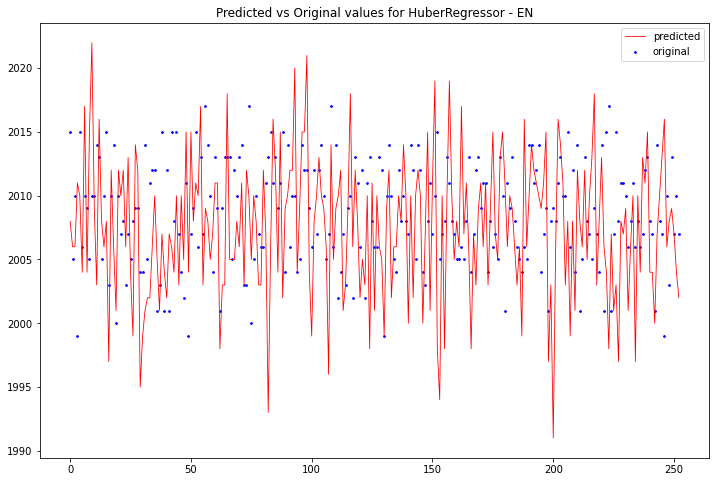

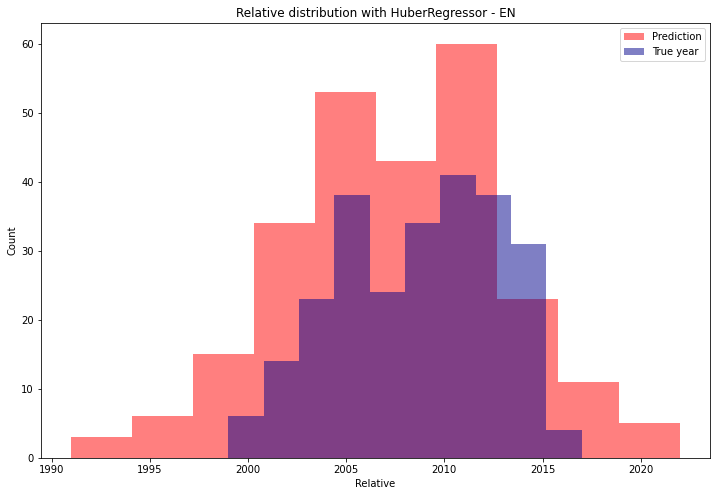

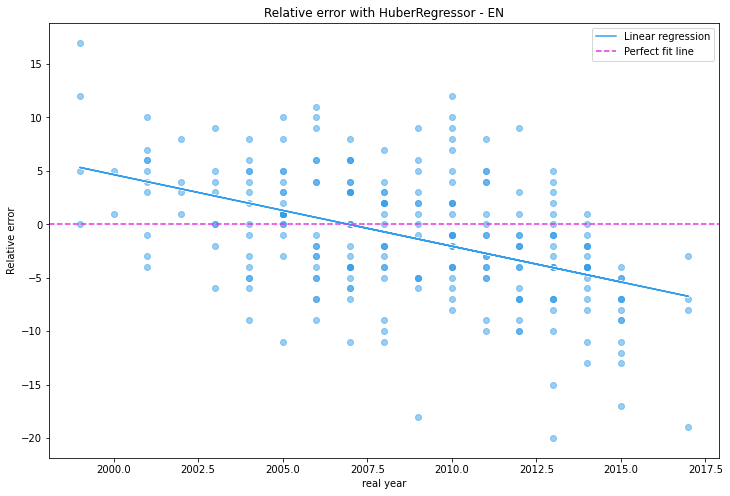

In [ ]:
models(HuberRegressor())

With this last model, the predicted values are very spread out compared to the previous models which has increased the MSE to 36.2. 


## **Models MSE PLOT**

Text(0.5, 1.0, 'Models MSE values - English Dataframe')

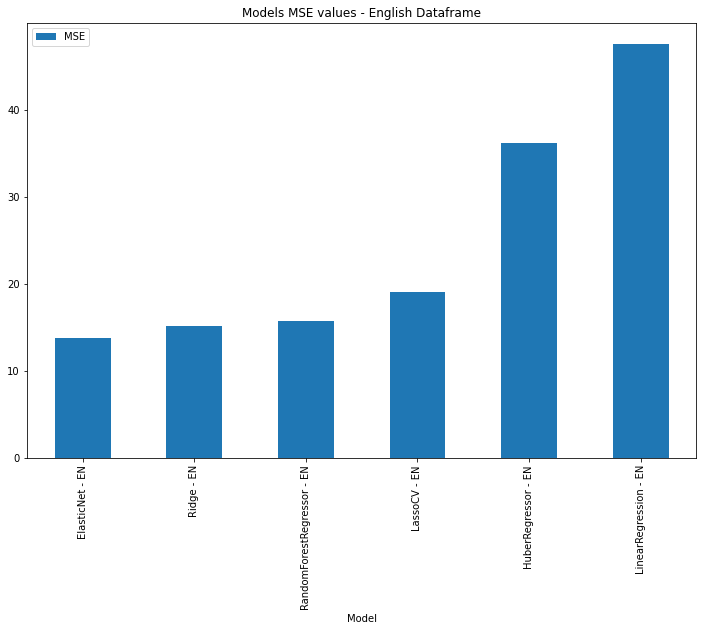

In [ ]:
df_English = pd.DataFrame({'Model':nameModelsEN, 'MSE':mseModelsEN}).sort_values('MSE')
ax = df_English.plot.bar(x='Model', y='MSE', rot=90, figsize=(12,8))
plt.title("Models MSE values - English Dataframe")


## English Models Conclusion

As a result, we can see that Elastic Net had the lowest Mean Squared Error meaning that the average squared difference between the estimated values and the actual value is at its lowest when using this model. 
Our worst model has is Linear Regression as its 56 (a difference of 43) with the best model.   

Additionally, throughout the different plots of the models we can see that the English abstracts predicts the publication dates of the articles mostly between the years 2005 and 2014. This is due to the fact that 70% of the articles in our dataset were published in those 9 years (894 articles out of 1264). It is harder for our models to predict the values in between before 2005 and after 2014 as only 30% of the articles were written at that time. 


# FRENCH

For the french models, we do not detail each model as we already used them for the english models. We will do a global conclusion at the end.

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(XFrench, yFrench, test_size=0.2, random_state=0, shuffle=True)

In [ ]:
mseModels= []
nameModels= []

Model : LinearRegression - FR
MSE: 70.97394136807817


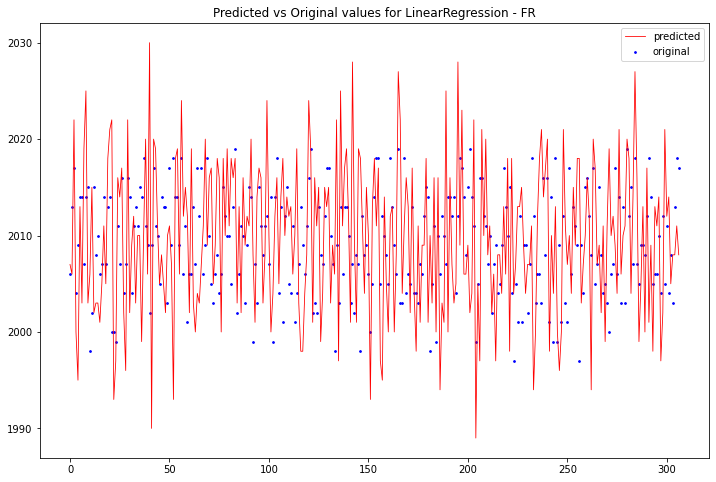

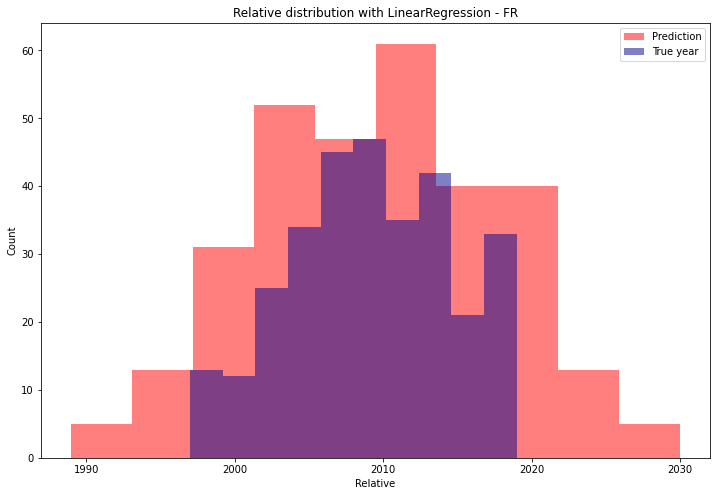

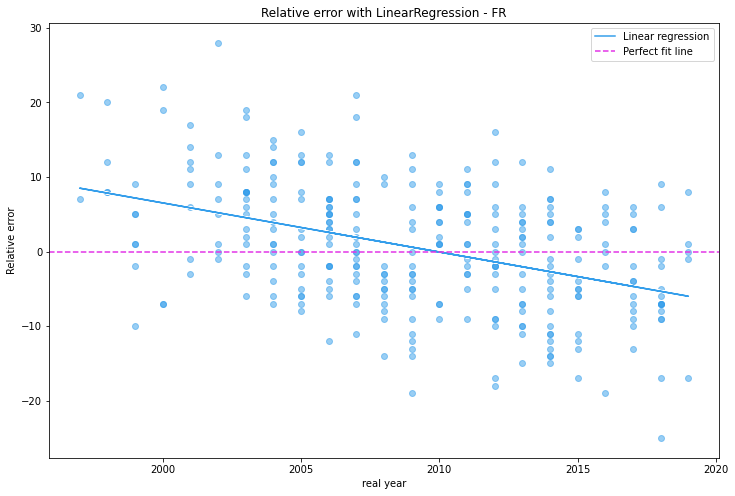

In [ ]:
models(LinearRegression(), 'FR')

In [ ]:
alphas = [0.000001, 0.00001, 0.0001, 0.001, 0.01, 0.1,0.5, 1]
for a in alphas:
  model = Ridge(alpha=a, normalize=True).fit(X_train,y_train) 
  score = model.score(X_test, y_test)
  pred_y = model.predict(X_test)
  mse = mean_squared_error(y_test, pred_y) 
  print("Alpha:{0:.6f}, R2:{1:.3f}, MSE:{2:.2f}, RMSE:{3:.2f}"
      .format(a, score, mse, np.sqrt(mse)))

Alpha:0.000001, R2:-0.027, MSE:29.59, RMSE:5.44
Alpha:0.000010, R2:-0.027, MSE:29.59, RMSE:5.44
Alpha:0.000100, R2:-0.027, MSE:29.59, RMSE:5.44
Alpha:0.001000, R2:-0.026, MSE:29.57, RMSE:5.44
Alpha:0.010000, R2:-0.022, MSE:29.46, RMSE:5.43
Alpha:0.100000, R2:0.011, MSE:28.49, RMSE:5.34
Alpha:0.500000, R2:0.097, MSE:26.02, RMSE:5.10
Alpha:1.000000, R2:0.145, MSE:24.63, RMSE:4.96


Model : Ridge - FR
MSE: 24.635179153094462


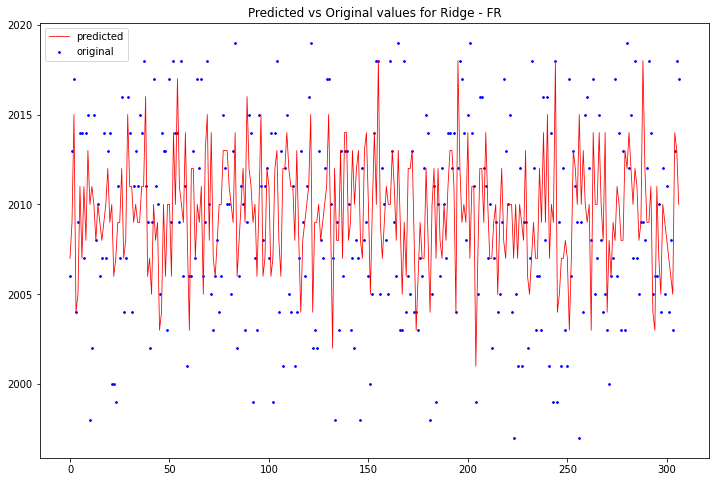

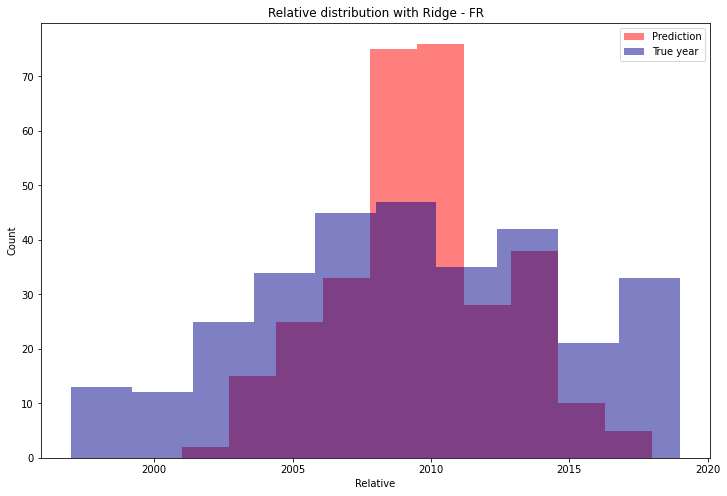

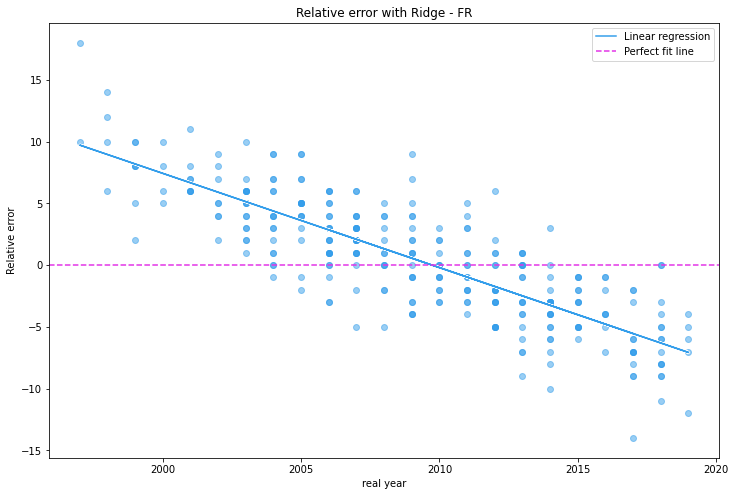

In [ ]:
models(Ridge(alpha=1, normalize=True), 'FR')

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 15.50141119427876, tolerance: 2.8230142711518864
  positive)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 18.118153758472435, tolerance: 2.7741963302752257
  positive)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 23.33289157605901, tolerance: 2.7559447046843153
  positive)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 17.94676

Model : LassoCV - FR
MSE: 32.1042345276873


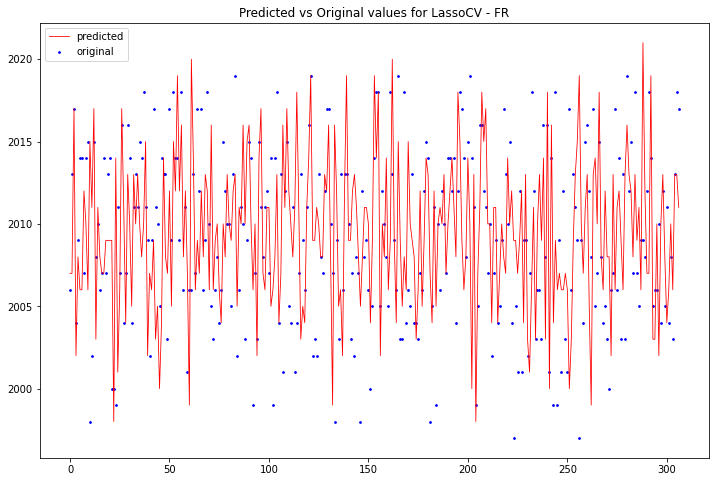

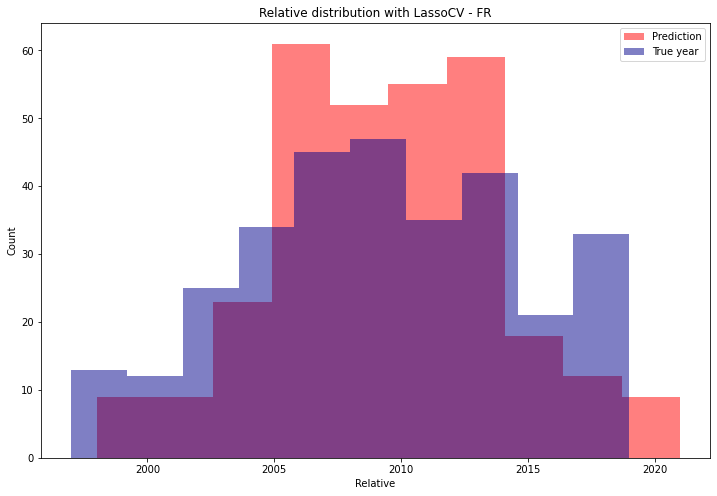

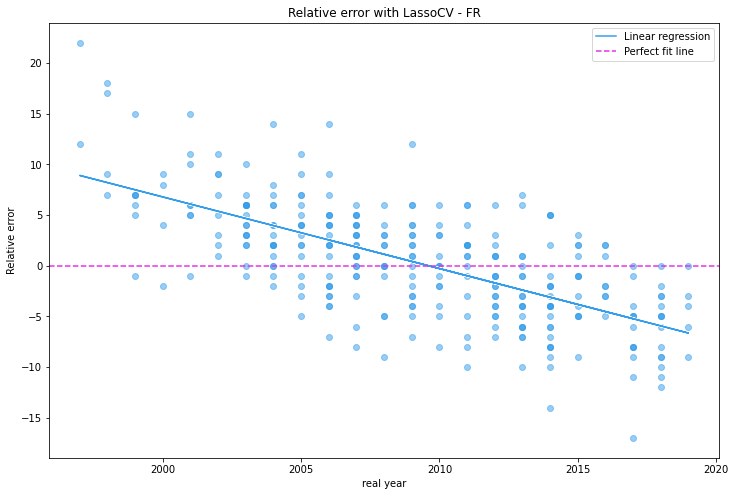

In [ ]:
models(LassoCV(alphas=[0.00001], cv=5), 'FR')

In [ ]:
alphas = [0.0001, 0.001, 0.01, 0.1, 0.3, 0.5, 0.7, 1]
for a in alphas:
    model = ElasticNet(alpha=a).fit(X_train,y_train)   
    score = model.score(X_test, y_test)
    pred_y = model.predict(X_test)
    mse = mean_squared_error(y_test, pred_y)   
    print("Alpha:{0:.4f}, R2:{1:.2f}, MSE:{2:.2f}, RMSE:{3:.2f}"
       .format(a, score, mse, np.sqrt(mse)))

Alpha:0.0001, R2:0.09, MSE:26.15, RMSE:5.11
Alpha:0.0010, R2:0.22, MSE:22.50, RMSE:4.74
Alpha:0.0100, R2:0.09, MSE:26.35, RMSE:5.13
Alpha:0.1000, R2:-0.01, MSE:29.11, RMSE:5.40
Alpha:0.3000, R2:-0.01, MSE:29.11, RMSE:5.40
Alpha:0.5000, R2:-0.01, MSE:29.11, RMSE:5.40
Alpha:0.7000, R2:-0.01, MSE:29.11, RMSE:5.40
Alpha:1.0000, R2:-0.01, MSE:29.11, RMSE:5.40


Model : ElasticNet - FR
MSE: 22.576547231270357


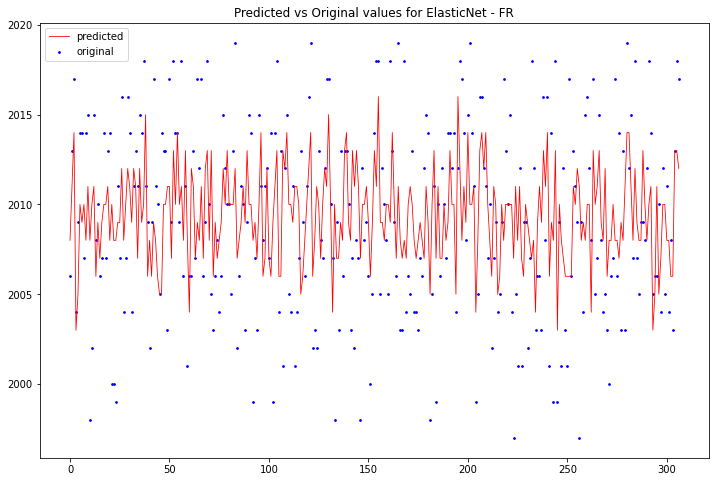

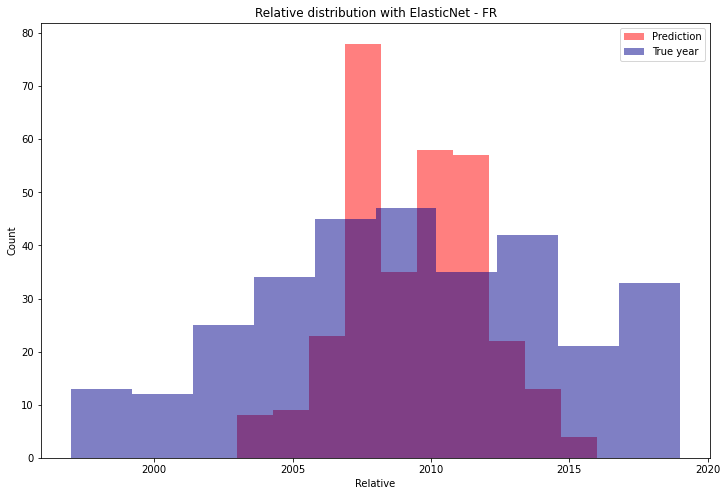

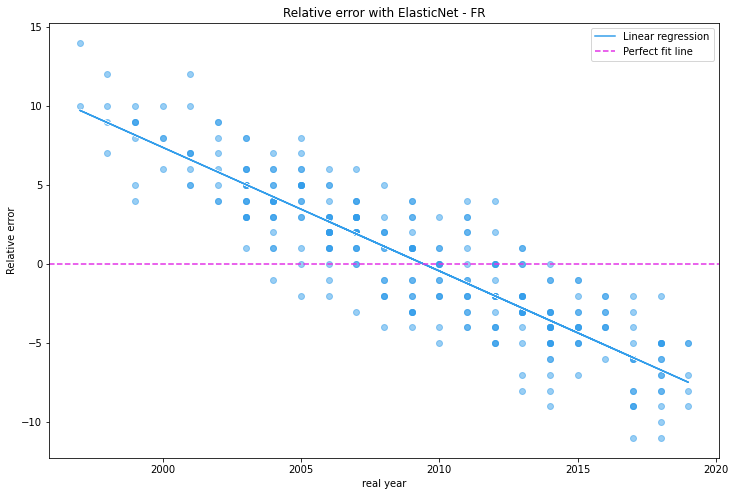

In [ ]:
models(ElasticNet(alpha=0.001), 'FR')

Model : RandomForestRegressor - FR
MSE: 24.218241042345277


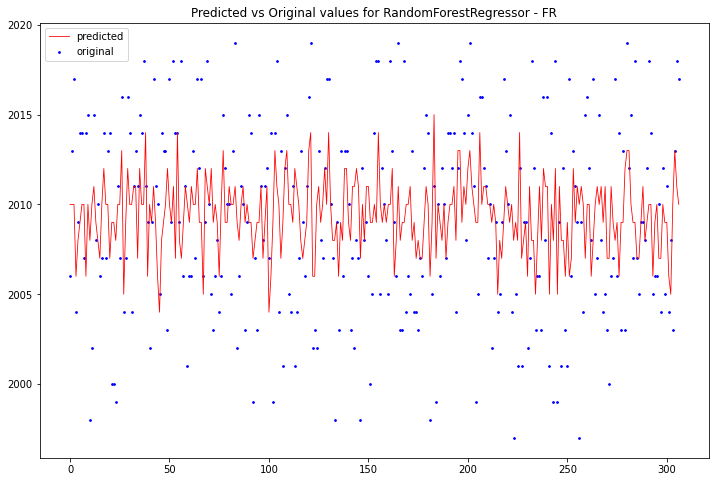

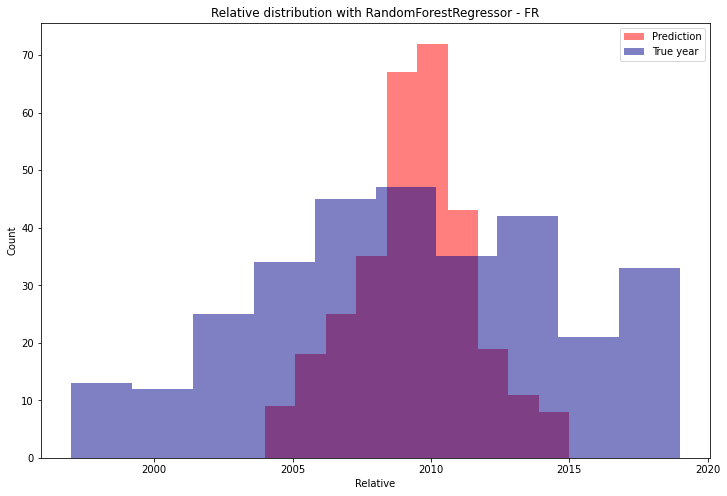

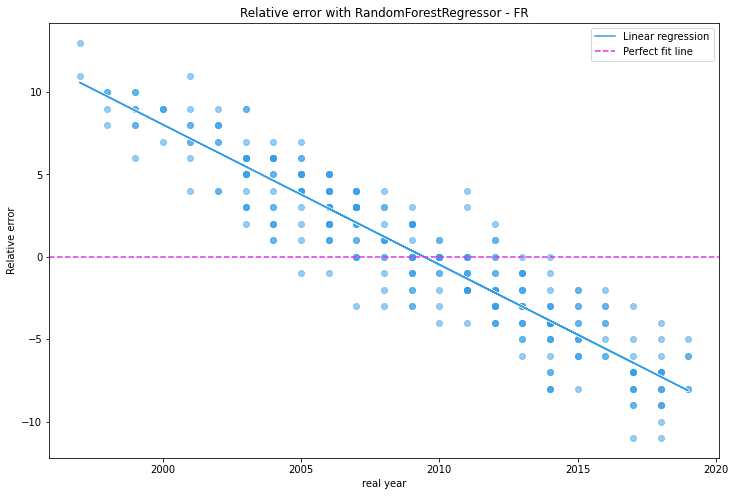

In [ ]:
models(RandomForestRegressor(), 'FR')

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_huber.py:296: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


Model : HuberRegressor - FR
MSE: 40.60586319218241


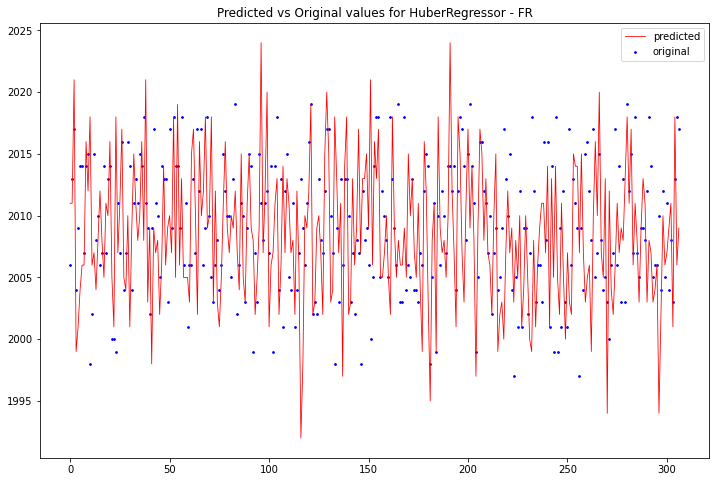

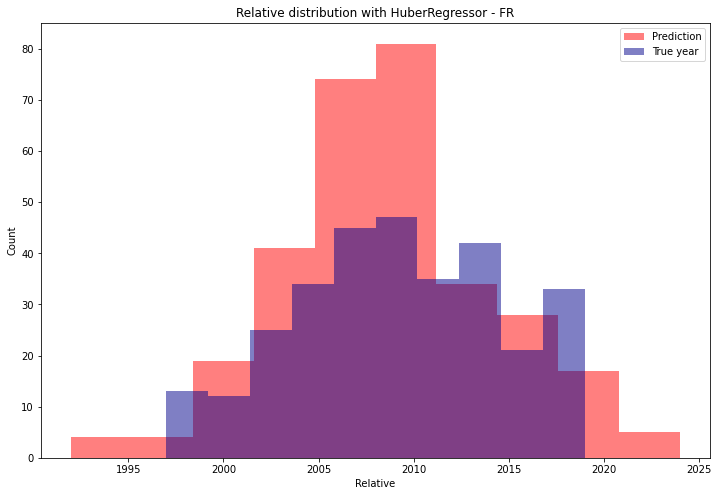

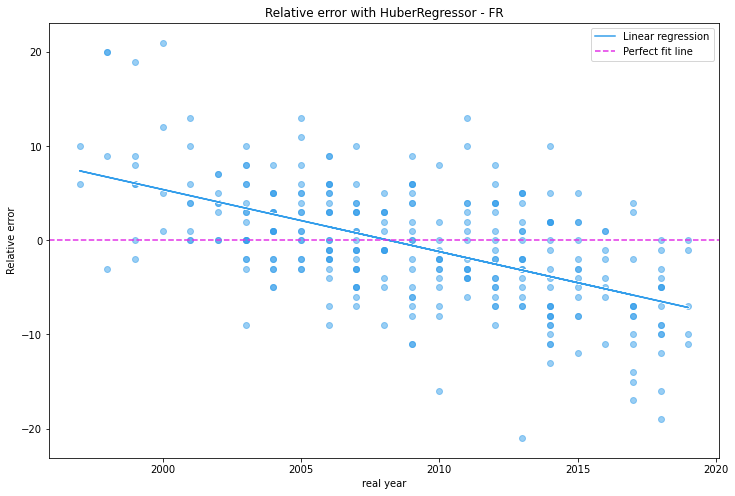

In [ ]:
models(HuberRegressor(), 'FR')

Text(0.5, 1.0, 'Models MSE values - French Dataframe')

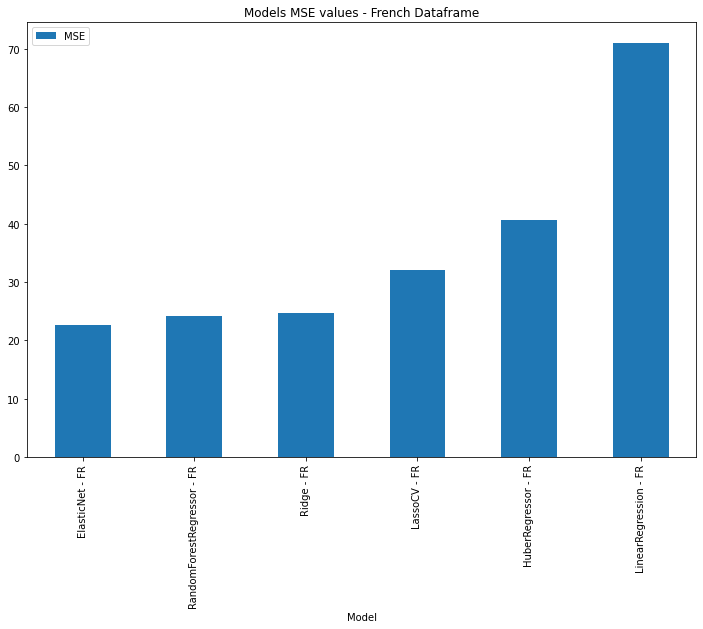

In [ ]:
df_French = pd.DataFrame({'Model':nameModelsFR, 'MSE':mseModelsFR}).sort_values('MSE')
ax = df_French.plot.bar(x='Model', y='MSE', rot=90, figsize=(12,8))
plt.title("Models MSE values - French Dataframe")

We remark that, as for the English MSE values, Linear Regression has the worst as it is more than 70 and Elastic Net has the best with a value of less than 25 for the MSE. 

Text(0.5, 1.0, 'Models MSE values - French vs English')

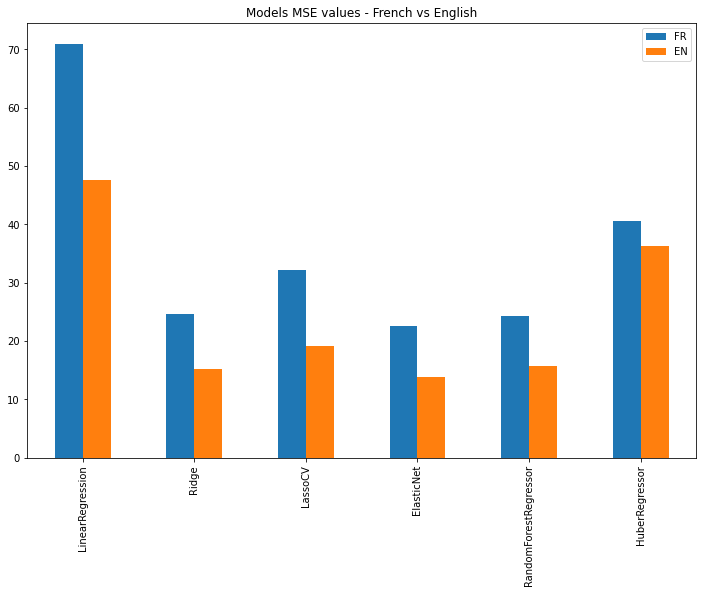

In [ ]:
modelNames = []
for name in nameModelsFR:
  modelNames.append(name.replace(' - FR', ''))

df = pd.DataFrame({'FR': mseModelsFR,
                   'EN': mseModelsEN}, index=modelNames)
ax = df.plot.bar(rot=90, figsize=(12,8))
plt.title("Models MSE values - French vs English")

Throughout the different models, we can observe that there is a correlation between the English MSE and the French MSE. 
For the english abstracts, our model's predictions are in the same order for the MSE values. However, the french models MSE values are much higher than the english models MSE values. 


*   Linear Regression: MSE -> 70.9  for the model vs MSE -> 56.0 for the english model
*   Elastic Net: MSE -> 22.57 for the french model vs MSE -> 13 for the english model 

Therefore, we can notice the most difficult abstracts for the models to predict is to predict the publication date of an abstract written before 2005 or after 2014 in french. The publication dates of the english abstracts written between 2005 and 2014 will have a higher precision. 

